# 一か八かを生成する 

最小限のdiffusionモデルを用いて，1か8かの画像を生成します．  
より複雑なモデルは次の章で扱います．この章のセルを全て飛ばしても進むことができます．

## セットアップ

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


## 学習データの用意

In [3]:
dataset = torchvision.datasets.MNIST(root="/data", train=True, download=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [5]:
target_values = [1, 8, 4]

target_images = []
data_info_dict = {}
for k in target_values:
    data_info_dict[k] = 0

for data in dataset:
    if data[1] in target_values:
        target_images.append(data)
        data_info_dict[data[1]] += 1

for k, v in data_info_dict.items():
    print(f"the number of <{k}> images is {v}")

the number of <1> images is 6742
the number of <8> images is 5851
the number of <4> images is 5842


In [8]:
train_dataloader = DataLoader(target_images, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 4, 8, 4, 1, 4, 1, 8])


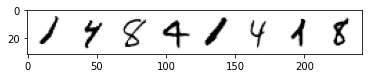

In [9]:
# データを1つ(batch_size = 8)取り出して例示
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

各画像は28*28のベクトルで，各要素は0~1の実数値を取ります．

## 画像にノイズを加える

In [16]:
def corrupt(x, amount):
  """
    x : 入力する画像(複数), x.shape = torch.Size([batch_size, 1, 28, 28])
    amount : 各画像にどれだけノイズを入れるかの比率を入れたndarray, 0->そのまま, 1->完全にノイズ
  """
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) 
  return x*(1-amount) + noise*amount 

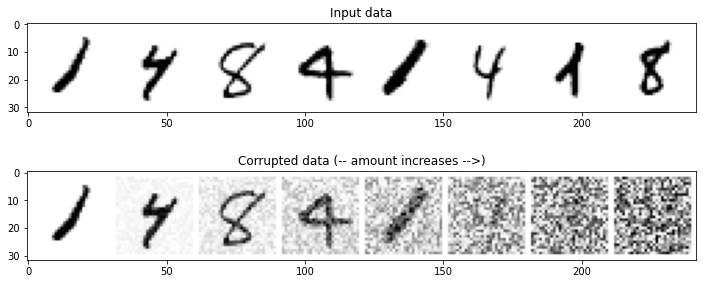

In [17]:
# ノイズが加わる様子を可視化
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

_, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## 学習に用いるモデル

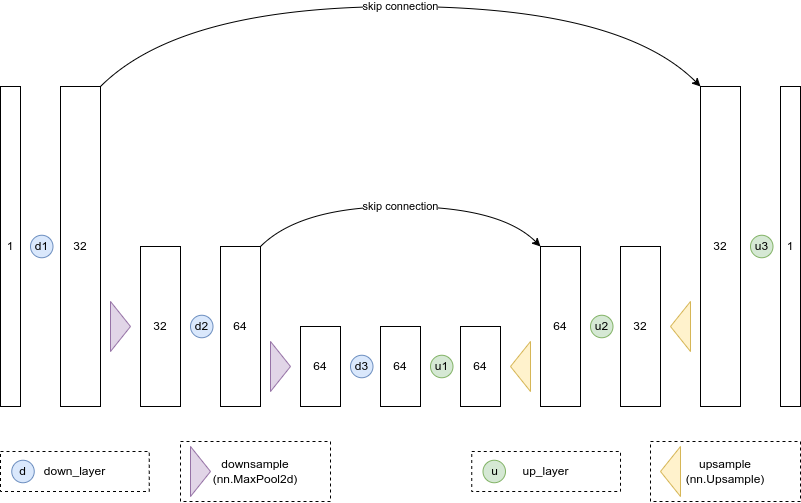

ここでは，ごく単純なUNetを用います．構造は上の画像の通りで，以下のように組まれます．

In [18]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.down_layer1 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
        self.down_layer2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.down_layer3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        
        self.up_layer1 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.up_layer2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.up_layer3 = nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        x1 = self.act(self.down_layer1(x))
        x2 = self.downscale(x1)
        x2 = self.act(self.down_layer2(x2))
        x3 = self.downscale(x2)
        x3 = self.act(self.down_layer3(x3))

        y = self.act(self.up_layer1(x3))
        y = self.upscale(y) + x2
        y = self.act(self.up_layer2(y))
        y = self.upscale(y) + x1
        y = self.act(self.up_layer3(y))
        return y

In [19]:
# 出力サイズが入力サイズと等しいことの確認
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [20]:
# パラメータ数
sum([p.numel() for p in net.parameters()])

309057

## モデルの学習

1 epochにつき90秒ほどかかります．

Finished epoch 0. Average loss for this epoch: 0.027452
Finished epoch 1. Average loss for this epoch: 0.020541
Finished epoch 2. Average loss for this epoch: 0.018492
Finished epoch 3. Average loss for this epoch: 0.017243
Finished epoch 4. Average loss for this epoch: 0.016408


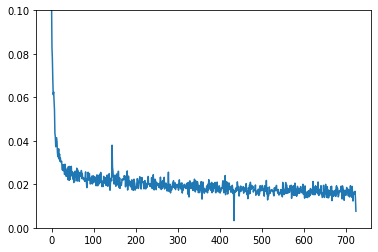

In [22]:
batch_size = 128
train_dataloader = DataLoader(target_images, batch_size=batch_size, shuffle=True)

max_epochs = 5

net = BasicUNet()
net.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 

history = []
for epoch in range(max_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        # どれくらいノイズを入れるかは乱数で決める
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)
        loss = loss_func(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.append(loss.item())

    avg_loss = sum(history[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(history)
plt.ylim(0, 0.1);

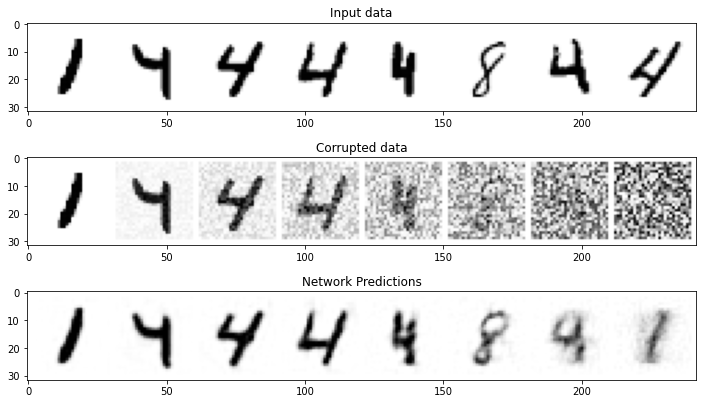

In [23]:
# 学習データを用いて推論し，出力を確認してみる
x, y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

_, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys')

入力がノイズの少ない画像(Corrupted data)の時にはうまくノイズを除去できていそうです．  
しかし，ノイズが多い場合には除去しきれず残っているようです．

ちなみに，もしかしたら完全なノイズを入力した時の推論結果は，学習に用いた教師画像の平均になるのではないかと思うかもしれません．  
実際に元の教師画像全ての平均を取ると以下のようになります．  
つまり，推論では単なる入力の平均にはならず，教師画像のうちのどれかの特徴を捉えたような出力が得られています．

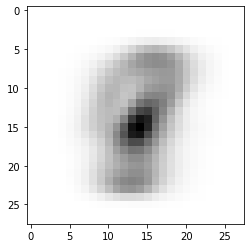

In [29]:
sum = target_images[0][0]
for i in target_images[1:]:
    sum += i[0]
plt.imshow(sum[0]/len(target_images), cmap='Greys')

## サンプリングにより画像を生成する

完全ランダムなノイズを入力すると，ノイズを除去しきれずぼやっとした画像が得られてしまいます．しかし，得たい画像の特徴は少し捉えています．  
一方で，ノイズが少しだけ乗った画像を入力すると，うまくノイズを除去した画像が得られます．

そこで，完全ランダムなノイズから始めて推論を複数ステップ重ねれば，徐々に良い出力へと近づいていくと期待できます．  
なお，モデルは人為的にノイズを加えた画像を入力に取るので，ノイズを加える過程と推論を交互に行う必要があります．

（こうすることで，初期の方のステップにおける推論のエラーも，後半までには修復できるでしょう）

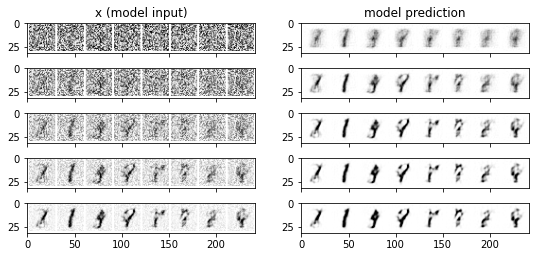

In [30]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())

    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor
    step_history.append(x.detach().cpu())

_, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

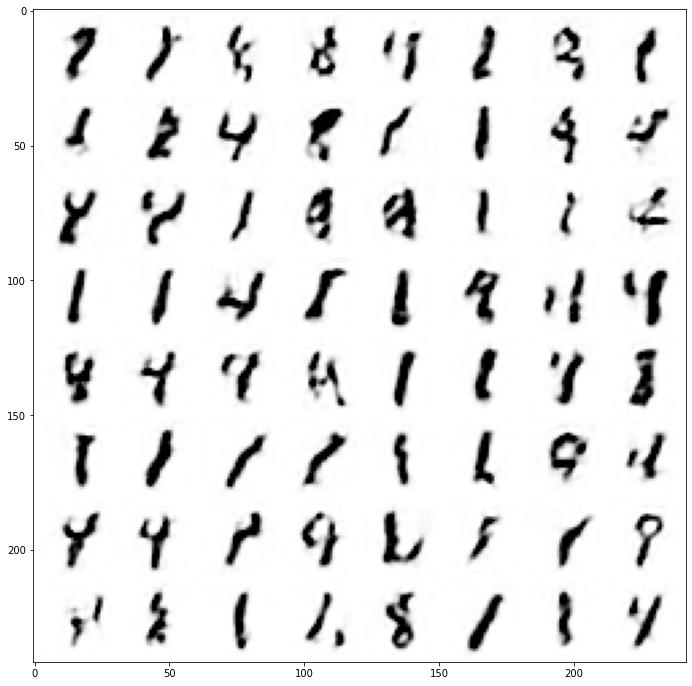

In [31]:
# サンプリングのステップ数を増やしてみる
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)

for i in range(n_steps):
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

完璧ではないですが，1か8または4の生成に成功しているようです．

1がやや多いのは，学習データの量が多かったことも関係あるかもしれません．